In [1]:
!pip install tensorflow

     |███████████████████████████▍    | 274.5 MB 118.2 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 320.4 MB 18 kB/s 
     |████████████████████████████████| 127 kB 90.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.8 MB 73.7 MB/s eta 0:00:01
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     |████████████████████████████████| 65 kB 5.7 MB/s  eta 0:00:01
     |████████████████████████████████| 459 kB 96.9 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 3.8 MB 59.6 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 64.0 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 99.0 MB/s eta 0:00:01
     |████████████████████████████████| 88 kB 2.2 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 94.8 MB/s eta 0:00:01
     |████████████████████████████████| 147 kB 101.9 MB/s eta 0:00:01
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4830 sha256=752cd5f8d3dd122c45d67dbe1c2039a57d82

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from math import ceil
import seaborn as sns
from scipy import stats

In [3]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [4]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Patient Real Heart Rate')
    plt.plot(predicted, color='blue',label='Patient Predicted Heart Rate')
    plt.title('Heart Rate Prediction')
    plt.xlabel('Time')
    plt.ylabel('mV')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae =mean_absolute_error(test, predicted)
    print(f"The mean absolute error is {mae}.")

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [6]:
def create_time_steps(length):
    return list(range(-length, 0))

In [7]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History',kind='line')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future',kind='line')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In [8]:
tf.random.set_seed(13)

In [9]:
df = pd.read_csv('../../data/raw/fibrilacao.txt',sep=' ',index_col = 'time')
df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Unnamed: 0,fibrilacao_1,fibrilacao_2
time,,,
0.000,NaN,0.05250,0.09000
0.004,NaN,0.05125,0.09625
0.008,NaN,0.04875,0.10250
0.012,NaN,0.04375,0.10125
0.016,NaN,0.03625,0.10250


In [10]:
df.drop(columns = 'Unnamed: 0',inplace = True)

In [11]:
int(df.shape[0] * 0.5)

1149625

In [12]:
df.tail(5)

,fibrilacao_1,fibrilacao_2
time,,
9196.980,-0.09500,0.10625
9196.984,-0.10125,0.10375
9196.988,-0.10250,0.10000
9196.992,-0.10125,0.09625
9196.996,-0.09875,0.09000


## Training for 60% of the base

In [13]:
train = df.iloc[0:int(df.shape[0]*0.495)].values

In [14]:
test = df.iloc[int(df.shape[0]*0.495):].values

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


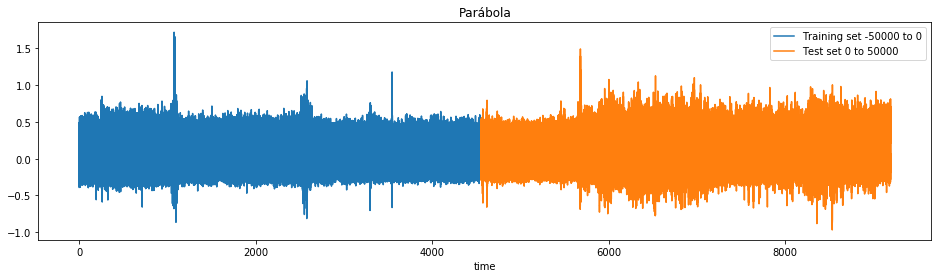

In [15]:
df["fibrilacao_1"].iloc[0:int(df.shape[0]*0.495)].plot(figsize=(16,4),legend=True)
df["fibrilacao_1"].iloc[int(df.shape[0]*0.495):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set -50000 to 0',f'Test set 0 to 50000'])
plt.title('Parábola')
plt.show()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


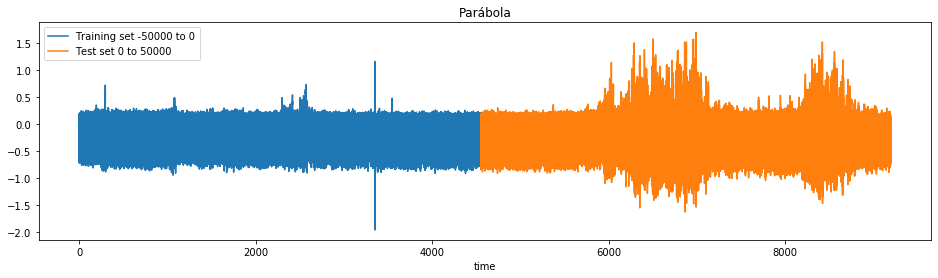

In [16]:
df["fibrilacao_2"].iloc[0:int(df.shape[0]*0.495)].plot(figsize=(16,4),legend=True)
df["fibrilacao_2"].iloc[int(df.shape[0]*0.495):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set -50000 to 0',f'Test set 0 to 50000'])
plt.title('Parábola')
plt.show()

In [17]:
uni_data = df['fibrilacao_1']
uni_data.head()

time
0.000    0.05250
0.004    0.05125
0.008    0.04875
0.012    0.04375
0.016    0.03625
Name: fibrilacao_1, dtype: float64

In [18]:
uni_data = uni_data.values

In [19]:
uni_train_mean = uni_data[:int(df.shape[0]*0.700)].mean()
uni_train_std = uni_data[:int(df.shape[0]*0.700)].std()

In [20]:
uni_train_mean

-0.03134025924602742

In [21]:
uni_train_std

0.14047028210305537

Let's standardize the data.

In [22]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [23]:
univariate_past_history = 1200
univariate_future_target = 10

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.700),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.700), None,
                                       univariate_past_history,
                                       univariate_future_target)

# Model testing

In [24]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='swish',recurrent_activation='tanh'))
multi_step_model.add(tf.keras.layers.Dense(1))

tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [25]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(150).batch(450).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(450).repeat()

Batch de 100 com shuffle de 50 não roda bem

In [26]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=5,
                                          steps_per_epoch=30,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/5
30/30 [==============================] - 82s 3s/step - loss: 0.6008 - val_loss: 1.0561
Epoch 2/5
30/30 [==============================] - 79s 3s/step - loss: 0.5831 - val_loss: 1.0508
Epoch 3/5
30/30 [==============================] - 79s 3s/step - loss: 0.5043 - val_loss: 0.9308
Epoch 4/5
30/30 [==============================] - 81s 3s/step - loss: 0.4514 - val_loss: 0.8837
Epoch 5/5
30/30 [==============================] - 80s 3s/step - loss: 0.5012 - val_loss: 0.8589


#### Swish - Sigmoid
- a função possui um loss bem proximo de seu validation durante todo o treinamento.
- elas começam a convergir mais para o final.
- na ultima época temos um loss e um validation loss bem próximos, na casa dos 10%
- Com Swish temos um ganho na distância das ondas, aqui a distância é de 2.

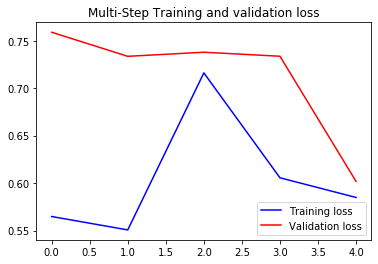

In [37]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [39]:
STEP = 1

result for ks on test is KstestResult(statistic=0.18887780789585362, pvalue=1.3780876072724606e-28)
result for ks on prediction is KstestResult(statistic=0.8890072545841601, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.4168870548362088, pvalue=3.761594991857391e-39)


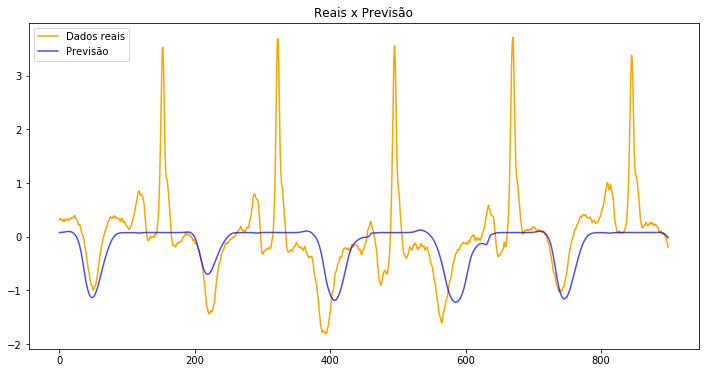

In [40]:
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

#### Swish - tanh

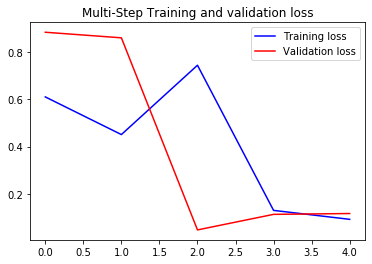

In [28]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.7368692996713779, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.7558181851012544, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=1.0, pvalue=0.0)


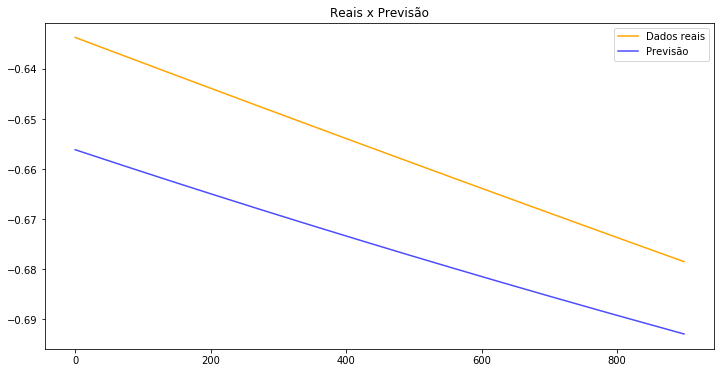

In [30]:
STEP = 1
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

## Plottar O gráfico de -1000 a 1000
## Manter batchs maiores, próximos do nosso passado de treinamento

### Fazer um com tanh 
- testar com outros

#### Swish - TanH - 30 Steps
- Preciso diminuir o número de dados para enchergar melhor a curva do U

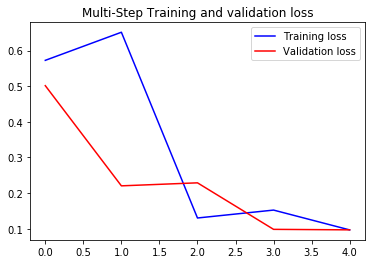

In [38]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

result for ks on test is KstestResult(statistic=0.8703842070156742, pvalue=0.0)
result for ks on prediction is KstestResult(statistic=0.8397672733757366, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9999987037017926, pvalue=0.0)


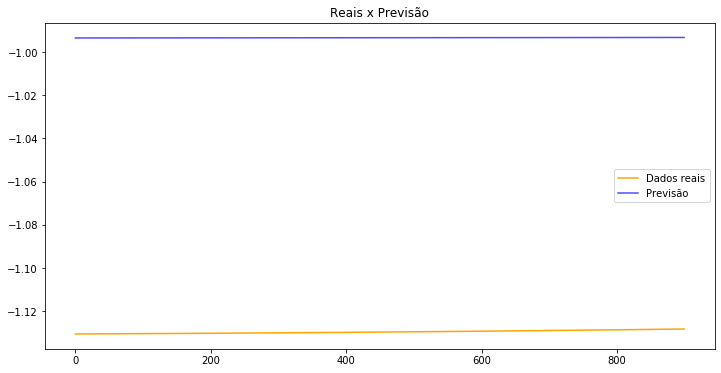

In [40]:
STEP = 1
for x, y in val_data_multi.take(1):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.legend(['Dados reais','Previsão'])
    plt.title('Reais x Previsão')
    plt.show()

### Fazer para 125 e 50Hz